**Introduction to Bioinformatics**<br>
A masters course by Blaž Zupan and Tomaž Curk<br>
University of Ljubljana, 2016-2018

Disclaimer: this work is a first draft of our working notes. The images were obtained from various web sites, but mainly from the wikipedia entries with explanations of different biological entities. Material is intended for our 2016 class and is not meant for distribution.

## Lecture Notes Part 3

# Some Statistics on Finding Unusual DNA Words

The last time we have finished with counting the $k$-mers, that is, short subsequences of nucleotides in the DNA. Let us stick with Lambda phage because of its compact genome, and check some code we have used the last time. Remember, we were counting the pairs (words of length $k=2$) of the successive nucleotides in the genome and estimating the probability of encountering a particular word if we would arbitrarily draw a word from the sequence. We used relative frequency for estimated probability. We also said that dinucleotide CG, often written by CpG to differentiate it with a CG content, has some interesting biological meaning. Instead of observing all different words, let us concentrate on CpGs only.

Let us start by reading the data. If you wonder where did we get the FASTA sequence file from, check out the previous lecture.

In [1]:
from Bio import SeqIO
file_name = "p_lambda"
s = str(SeqIO.read("data/%s.fasta" % file_name, "fasta").seq)
print("Sequence lenght: %d bp" % len(s))

Sequence lenght: 48502 bp


We would like to count how many times a specific word (like CG) occurs in the sequence. Let us do this using a generator function and use it to write a function that counts occurrences of a specific word.

In [2]:
def tuple_walk(s, k=2):
    """Generate subsequences of length k."""
    for i in range(len(s)-1):
        yield s[i:i+k]

def count_tuple(s, w):
    """Count words w in sequence s."""
    return sum(1 for ss in tuple_walk(s, len(w)) if ss == w)

Let us try this out on our sequence.

In [3]:
w = "CG"
cpgs = count_tuple(s, w)
cpgs

3113

There are 3,113 CpGs in Lambda phage. How many would we expect if the constitution of the sequence would be random, that is, would bear no particular structure?

In [4]:
from collections import Counter
from operator import mul
from functools import reduce

def product(lst):
    return reduce(mul, lst, 1)

n = len(s)
p_nucleotide = {k: v/float(n) for k, v in Counter(s).items()}
p = product(p_nucleotide[x] for x in w)
int(p * n)

3003

If the sequence would not have any structure, that is, its composition would come from the same multinomial distribution as original sequence, but the sequence would be random, the number of CpGs would in Lambda phage be 3,003.

Ok. So we have a few more CpGs in this virus than expected by chance. But we could have this just by chance. That is, for sure there is some random permutation of the Lambda phage genome where the number of CpGs is 3,113. Why random permutation? Ah, because the sequence we get by random permutation of the nucleotides has the same nucleotide counts as the original sequence, that is, comes from the equal multinomial distribution. And because the sequence that we get by a random permutation is random. If we would observe that in a randomly permuted sequence the number of CpGs is often around 3,113 or better, is usually higher than this number, that we could not claim that the number of CpGs in original sequence is anything special. In that case and concerning CpGs, the original sequence would not have any particular structure. It would be just as any random sequence.

## Permutation Test

This thinking leads to something that we call a permutation test. Let's permute the sequence, counts occurrences of CpG, and do this many times. Say, 1,000 times.

In [5]:
import random

def permutation_counts(seq, t, epochs=1000):
    seq = list(seq)
    counts = []
    for i in range(epochs):
        random.shuffle(seq)
        counts.append(count_tuple("".join(seq), t))
    return counts

In [6]:
random.seed(42)
cs = permutation_counts(s, w, 1000)

It takes a minute to compute this (luckily, the genome of Lambda phage is quite short). Let us have a look at the few first entries of the count list.

In [7]:
cs[:10]

[2988, 2988, 3028, 2991, 3000, 3018, 3051, 3015, 3042, 2980]

Nothing bigger than 3113. Actually, how many counts are equal or bigger to 3113?

In [8]:
sum(c>=cpgs for c in cs)

7

There are seven such counts. Let us see which ones.

In [9]:
[c for c in cs if c>=cpgs]

[3120, 3126, 3170, 3124, 3160, 3117, 3153]

It would also help us to see how CpG counts are distributed across all of the permutation tests. We can plot a histogram to observe the estimation of the actual distribution of CpGs in the random sequences:

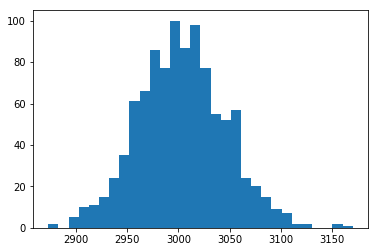

In [10]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.hist(cs, 30);

So, in a random world, the chance that we would get 3113 or more CpGs in a Lambda phage genome is

In [11]:
len([c for c in cs if c>=cpgs])/len(cs)

0.007

This is quite a small chance.

Now, consider the hypothesis that, concerning the CpGs, the structure of the genome is random. We would like to reject this hypothesis. If we reject it, we would not want to be wrong. Say, for rejection, it is ok to be wrong with the probability of 0.01. Let us called this threshold a significance level. In our case, we claimed that the structure of the genome is not random. If the structure were random, we would encounter 3,113 or more CpGs only in 7 out of 1000 random permutations of the genome, that is, we would encounter them with $p=0.007$. Now, this is less than our significance level, so we can reject the hypothesis that our number of CpGs arose by chance. We can even say that we have rejected null hypothesis with $p<0.01$.

Ha, we have just invented what statisticians are doing and calling statistical testing. Except that no distributions were involved. Why? Well, instead of some formal distribution we have estimated the distribution by permuting the genomes and eventually doing permutations tests. 

Are 1,000 permutations enough? Perhaps. It would help us, though, to use more permutations. Say, 10,000. For Lambda phage this would work, but for bigger sequences we would need to optimize the code and use some parallel processing. Instead, though, we could still ask some statisticians and query them if there is some formal distribution that we could use instead of performing permutation experiments. Often, for simple hypothesis such as our one, this would work, but sometimes permutation experiments are all we could do.

This still does not prevent you to think and read about [binomial distribution](https://en.wikipedia.org/wiki/Binomial_distribution). Can you use the binomial distribution to compute what is the chance that we would observe 3,113 CpGs in a random sequence?

## CpGs in Human?

We have talked about methylation and said that it occurs at CpGs and that can prevent transcription. Methylation is a gene expression regulation mechanisms that is in particularly used with higher-level organisms. So there should be fewer CpGs in human genome than expected by chance. Let us check this out. We will use the sequence of human chromosome 21.

In [14]:
file_name = "hsa_c21"
s = str(SeqIO.read("data/%s.fasta" % file_name, "fasta").seq)
len(s)

33543332

In [15]:
cpgs = count_tuple(s, w)
cpgs

364736

Counting CpGs in human chromosome 21 takes about 10 seconds. Quite some time. Let us check how many CpGs we would expect if the structure of this sequence would be random.

In [16]:
n = len(s)
counts = Counter(s)
p_nucleotide = {k: v/float(n) for k, v in counts.items()}
p = product(p_nucleotide[x] for x in w)
int(p * n)

1402283

There are way fewer CpGs in original sequence than expected by chance. We can do statistical testing here, and I bet the probably of getting so few CpGs from a random sequence is almost negligible. But while we would be tempted to compute this probably using permutation tests, such testing would take too long (I do not have patience for this here). Instead, we could estimate this chance by using binomial distribution.

In [17]:
from scipy.stats import binom
binom.cdf(cpgs, n, p)

0.0